In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
df = pd.read_csv('/content/drive/MyDrive/dataset/london_merged.csv', parse_dates=['timestamp'])
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [5]:
df['timestamp']

0       2015-01-04 00:00:00
1       2015-01-04 01:00:00
2       2015-01-04 02:00:00
3       2015-01-04 03:00:00
4       2015-01-04 04:00:00
                ...        
17409   2017-01-03 19:00:00
17410   2017-01-03 20:00:00
17411   2017-01-03 21:00:00
17412   2017-01-03 22:00:00
17413   2017-01-03 23:00:00
Name: timestamp, Length: 17414, dtype: datetime64[ns]

In [6]:
df.shape

(17414, 10)

In [7]:
train = df.iloc[:17000, 1:2]
test = df.iloc[17000:, 1:2]

In [8]:
print(train.shape)
print(test.shape)

(17000, 1)
(414, 1)


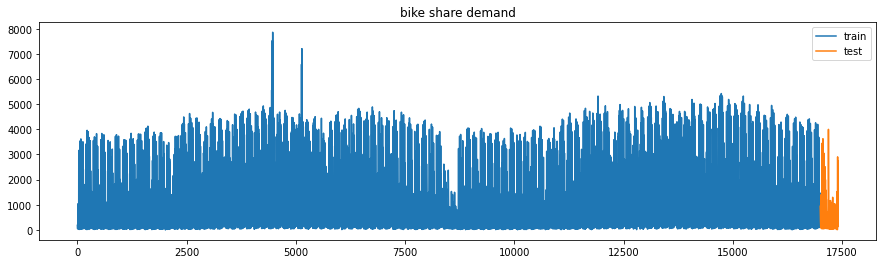

In [9]:
df['cnt'][:17000].plot(figsize=(15,4), legend=True)
df['cnt'][17000:].plot(figsize=(15,4), legend=True)

plt.legend(['train', 'test'])
plt.title('bike share demand')
plt.show()

차수 추정

: 얼마나 전 시점의 데이터로 미래를 예측할 것인가

In [10]:
from statsmodels.tsa.stattools import pacf
pacf = pacf(df['cnt'], nlags=20, method='ols')
print(pacf)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[ 1.          0.78148357 -0.41172684  0.18486682 -0.07510114 -0.09947694
 -0.08494917 -0.00403993  0.0920456   0.07065422 -0.32935188 -0.06873344
  0.05112775  0.04852911  0.06695059 -0.19621297 -0.07610221  0.14365297
 -0.11638129  0.18990804  0.16480713]


<bound method Figure.show of <Figure size 432x288 with 1 Axes>>

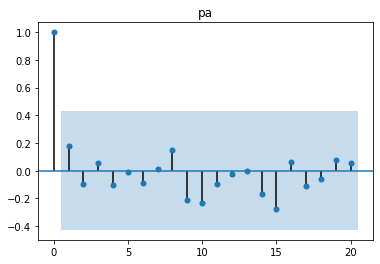

In [12]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(pacf, lags=20, method='ols', title='pa').show

전처리작업

In [13]:
# MinMaxScaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(train)

In [14]:
train_scaled

array([[0.02315522],
       [0.01755725],
       [0.01704835],
       ...,
       [0.17468193],
       [0.16348601],
       [0.14083969]])

In [15]:
# 한시간 단위로 시프트
# 독립변수와 종속변수 생성
X_train = []
y_train = []

for i in range(1, 17000):
    X_train.append(train_scaled[i-1:i, 0])
    y_train.append(train_scaled[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

In [16]:
X_train.shape

(16999, 1)

In [17]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(16999, 1, 1)

## RNN 

In [43]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import SimpleRNN

In [44]:
rnn = Sequential()
rnn.add(SimpleRNN(activation='relu', units=6, input_shape=(1,1)))
rnn.add(Dense(activation='linear', units=1))

In [45]:
print(rnn.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 6)                 48        
                                                                 
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
Total params: 55
Trainable params: 55
Non-trainable params: 0
_________________________________________________________________
None


In [46]:
rnn.compile(loss='mse', optimizer='adam', metrics=['mse'])

In [47]:
rnn.fit(X_train, y_train, batch_size=8, epochs=32)

Epoch 1/32
2125/2125 [==============================] - 5s 2ms/step - loss: 0.0079 - mse: 0.0079
Epoch 2/32
2125/2125 [==============================] - 4s 2ms/step - loss: 0.0076 - mse: 0.0076
Epoch 3/32
2125/2125 [==============================] - 4s 2ms/step - loss: 0.0076 - mse: 0.0076
Epoch 4/32
2125/2125 [==============================] - 4s 2ms/step - loss: 0.0076 - mse: 0.0076
Epoch 5/32
2125/2125 [==============================] - 4s 2ms/step - loss: 0.0076 - mse: 0.0076
Epoch 6/32
2125/2125 [==============================] - 4s 2ms/step - loss: 0.0076 - mse: 0.0076
Epoch 7/32
2125/2125 [==============================] - 6s 3ms/step - loss: 0.0076 - mse: 0.0076
Epoch 8/32
2125/2125 [==============================] - 5s 2ms/step - loss: 0.0076 - mse: 0.0076
Epoch 9/32
2125/2125 [==============================] - 4s 2ms/step - loss: 0.0076 - mse: 0.0076
Epoch 10/32
2125/2125 [==============================] - 4s 2ms/step - loss: 0.0076 - mse: 0.0076
Epoch 11/32
2125/2125 [======

In [48]:
inputs = sc.transform(test)
inputs.shape

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


(414, 1)

In [49]:
X_test = []
for i in range(1, 415):
    X_test.append(inputs[i-1:i, 0])
    
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(414, 1, 1)

In [50]:
rnn = rnn.predict(X_test)
rnn = sc.inverse_transform(rnn)

In [51]:
test1 = pd.DataFrame(test)
rnn1 = pd.DataFrame(rnn)

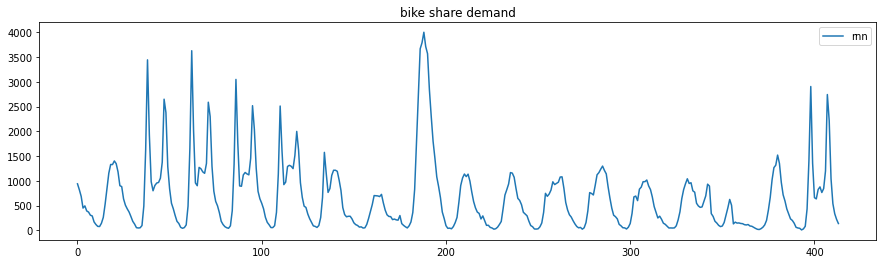

In [52]:
test1.plot(figsize=(15,4), legend=True)
plt.legend(['rnn'])
plt.title('bike share demand')
plt.show()

In [53]:
test = np.array(test)

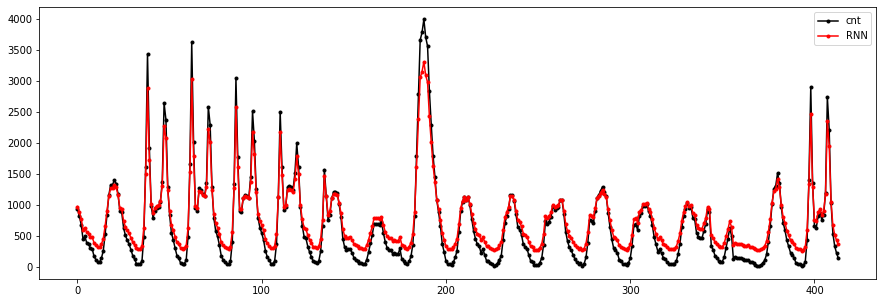

In [54]:
plt.figure(figsize=(15,5))
plt.plot(test, marker='.', label='cnt', color='black')
plt.plot(rnn, marker='.', label='RNN', color='red')
plt.legend()

## LSTM

In [56]:
from keras.layers.recurrent import LSTM
lstm = Sequential()
lstm.add(LSTM(units=6, activation='relu', input_shape=(1,1)))
lstm.add(Dense(units=1, activation='linear'))

In [57]:
print(lstm.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 6)                 192       
                                                                 
 dense_4 (Dense)             (None, 1)                 7         
                                                                 
Total params: 199
Trainable params: 199
Non-trainable params: 0
_________________________________________________________________
None


In [58]:
lstm.compile(loss='mse', optimizer='adam', metrics=['mse'])
lstm.fit(X_train, y_train, batch_size=8, epochs=32)

Epoch 1/32
2125/2125 [==============================] - 11s 3ms/step - loss: 0.0100 - mse: 0.0100
Epoch 2/32
2125/2125 [==============================] - 6s 3ms/step - loss: 0.0077 - mse: 0.0077
Epoch 3/32
2125/2125 [==============================] - 6s 3ms/step - loss: 0.0075 - mse: 0.0075
Epoch 4/32
2125/2125 [==============================] - 6s 3ms/step - loss: 0.0073 - mse: 0.0073
Epoch 5/32
2125/2125 [==============================] - 6s 3ms/step - loss: 0.0071 - mse: 0.0071
Epoch 6/32
2125/2125 [==============================] - 6s 3ms/step - loss: 0.0070 - mse: 0.0070
Epoch 7/32
2125/2125 [==============================] - 6s 3ms/step - loss: 0.0069 - mse: 0.0069
Epoch 8/32
2125/2125 [==============================] - 6s 3ms/step - loss: 0.0069 - mse: 0.0069
Epoch 9/32
2125/2125 [==============================] - 6s 3ms/step - loss: 0.0068 - mse: 0.0068
Epoch 10/32
2125/2125 [==============================] - 6s 3ms/step - loss: 0.0068 - mse: 0.0068
Epoch 11/32
2125/2125 [=====

In [59]:
lstm = lstm.predict(X_test)
lstm = sc.inverse_transform(lstm)

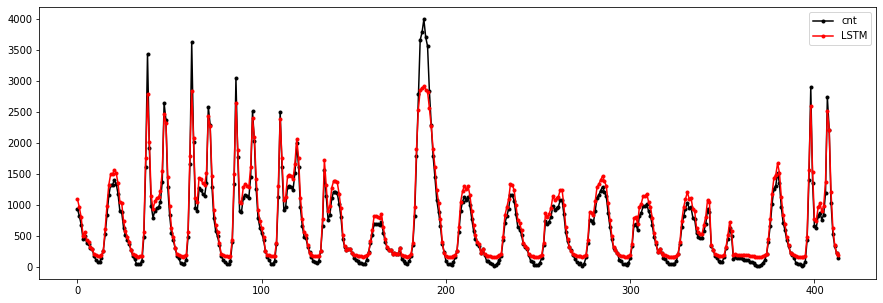

In [60]:
plt.figure(figsize=(15,5))
plt.plot(test, marker='.', label='cnt', color='black')
plt.plot(lstm, marker='.', label='LSTM', color='red')
plt.legend()

## GRU

In [62]:
from keras.layers.recurrent import GRU
gru = Sequential()
gru.add(GRU(units=6, activation='relu', input_shape=(1,1)))
gru.add(Dense(units=1, activation='linear'))

In [63]:
print(gru.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 6)                 144       
                                                                 
 dense_5 (Dense)             (None, 1)                 7         
                                                                 
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________
None


In [64]:
gru.compile(loss='mse', optimizer='adam', metrics=['mse'])
gru.fit(X_train, y_train, batch_size=8, epochs=32)

Epoch 1/32
2125/2125 [==============================] - 11s 3ms/step - loss: 0.0112 - mse: 0.0112
Epoch 2/32
2125/2125 [==============================] - 6s 3ms/step - loss: 0.0070 - mse: 0.0070
Epoch 3/32
2125/2125 [==============================] - 6s 3ms/step - loss: 0.0067 - mse: 0.0067
Epoch 4/32
2125/2125 [==============================] - 6s 3ms/step - loss: 0.0067 - mse: 0.0067
Epoch 5/32
2125/2125 [==============================] - 6s 3ms/step - loss: 0.0067 - mse: 0.0067
Epoch 6/32
2125/2125 [==============================] - 6s 3ms/step - loss: 0.0067 - mse: 0.0067
Epoch 7/32
2125/2125 [==============================] - 6s 3ms/step - loss: 0.0067 - mse: 0.0067
Epoch 8/32
2125/2125 [==============================] - 6s 3ms/step - loss: 0.0067 - mse: 0.0067
Epoch 9/32
2125/2125 [==============================] - 6s 3ms/step - loss: 0.0067 - mse: 0.0067
Epoch 10/32
2125/2125 [==============================] - 6s 3ms/step - loss: 0.0067 - mse: 0.0067
Epoch 11/32
2125/2125 [=====

In [65]:
gru = gru.predict(X_test)
gru = sc.inverse_transform(gru)

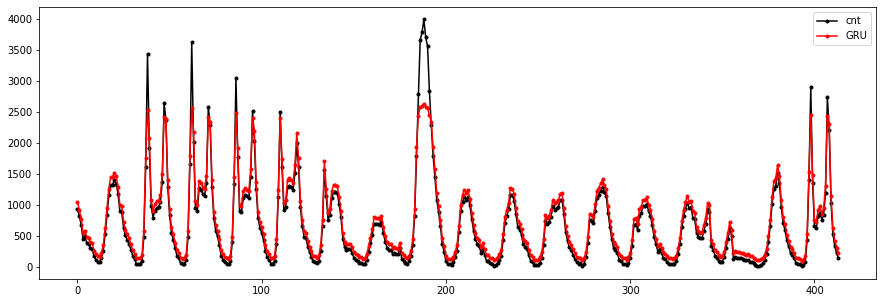

In [66]:
plt.figure(figsize=(15,5))
plt.plot(test, marker='.', label='cnt', color='black')
plt.plot(gru, marker='.', label='GRU', color='red')
plt.legend()

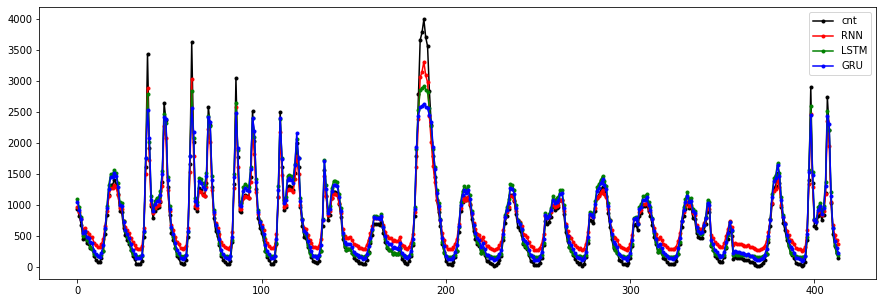

In [67]:
plt.figure(figsize=(15,5))
plt.plot(test, marker='.', label='cnt', color='black')
plt.plot(rnn, marker='.', label='RNN', color='red')
plt.plot(lstm, marker='.', label='LSTM', color='green')
plt.plot(gru, marker='.', label='GRU', color='blue')
plt.legend()

In [68]:
from sklearn.metrics import mean_squared_error

def RMSE(y_test, y_predict):
    return np.sqrt(mean_squared_error(y_test, y_predict))

In [69]:
print('RNN-RMSE : ', RMSE(test, rnn))
print('LSTM-RMSE : ', RMSE(test, lstm))
print('GRU-RMSE : ', RMSE(test, gru))

RNN-RMSE :  192.70222603628773
LSTM-RMSE :  159.13253516542113
GRU-RMSE :  180.6831284648711
